In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import rec_gym
from rec_gym.wrappers import StatsWrapper, FlattenObservationsWrapper
from copy import deepcopy
from rec_gym.runner import run_experiment

In [3]:
from agents.baselines import RandomAgent, DotProdAgent, MFAgent, DotProdAgent
from agents.dqn import Qagent
from agents.ddpg import DDPGAgent
import tensorflow as tf

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def prepare_random_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    action_size = env.unwrapped.n_rec
    agent = RandomAgent(action_size = action_size)    
    return agent, wrapped, env

def prepare_ddpg_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec


    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    agent = DDPGAgent(action_size = action_size,
                     state_dim = state_dim,
                     action_dim = action_dim,
                     gamma = .9,
                     sess = sess,
                     optimizer = tf.train.AdamOptimizer(
                         learning_rate=0.01
                     ),
                     max_tf_checkpoints_to_keep = 3,
                     experience_size = 300,
                     per = True,
                     batch_size = 64, 
                     start_steps = 400)
    sess.run(tf.global_variables_initializer())
    return agent, wrapped, env

def prepare_dqn_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec


    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    agent = Qagent(sess=sess,
                     state_dim=(state_dim,),
                     action_dim=(action_dim,),
                     epsilon=0.2,
                     action_size=action_size,
                     logdir=None,
                     replay_size=1000,
                     batch_size=50)
    sess.run(tf.global_variables_initializer())
    
    return agent, wrapped, env

def prepare_dotprod_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec

    agent = DotProdAgent(n_rec=action_size)
    return agent, wrapped, env

def prepare_mf_agent_and_env(base_env):
    env = deepcopy(base_env)
    wrapped = FlattenObservationsWrapper(env)
    unwrapped = env.unwrapped

    state_dim = unwrapped.embedding_dimension
    action_dim = unwrapped.embedding_dimension
    action_size = unwrapped.n_rec

    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    agent = MFAgent(n_rec=action_size, state_dim=state_dim, action_dim=action_dim, sess=sess)
    sess.run(tf.global_variables_initializer())
    return agent, wrapped, env

In [5]:
from collections import defaultdict
# [EnvId][Agent] = Interactions
results = defaultdict(dict)

In [6]:
from tqdm import tqdm_notebook

In [7]:
envids = [
#     'MovieLens-v1', 
#    'MovieLens-v2', 
#    'MovieLens-v3', 
#    'MovieLens-v4',
    'GenRecEnv-v1',
    'GenRecEnv-v2',
    'GenRecEnv-v3'
]
agents = {
        'dotprod' : lambda x : prepare_dotprod_agent_and_env(x),
        'random' : lambda x : prepare_random_agent_and_env(x),
        'dqn'    : lambda x : prepare_dqn_agent_and_env(x),
        'ddpg'   : lambda x : prepare_ddpg_agent_and_env(x),
        'mf_agent' : lambda x : prepare_mf_agent_and_env(x),
    }
n_steps = [ 
#     4000, 
#     4000, 
#     16000, 
#     16000, 
    2000, 
    2000, 
    2000
]

for envid, n_step in tqdm_notebook(zip(envids, n_steps), leave=True, position=0):

    base_env = StatsWrapper(gym.make(envid))
    base_env.unwrapped.n_rec

    for agent_name, prepare in agents.items():
        agent, wrapped, env = prepare(base_env)
        run_experiment(wrapped, agent, t_train=n_step, t_test=0)
        
        results[envid][agent_name] = env.interactions

  1%|          | 6/1000 [00:00<00:17, 57.07it/s]

WARN: <class 'rec_gym.wrappers.flatten_observation_wrapper.FlattenObservationsWrapper'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.


100%|██████████| 1000/1000 [00:12<00:00, 81.56it/s]
0it [00:00, ?it/s]
100%|██████████| 1000/1000 [00:11<00:00, 84.27it/s]
0it [00:00, ?it/s]
100%|██████████| 1000/1000 [01:50<00:00,  9.01it/s]
0it [00:00, ?it/s]
/home/anton/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
  6%|▋         | 63/1000 [00:00<00:12, 72.63it/s]/media/anton/0b9d5a44-bb63-4de1-9cfe-0da47b81e88a/TPT/3A/PRIM Vente Privee/rec_gym/agents/utils.py:275: RuntimeWarning: divide by zero encountered in double_scalars
  max_weight = (p_min * n) ** (-self.PER_b)
100%|██████████| 1000/1000 [01:54<00:00,  8.70it/s]
0it [00:00, ?it/s]
100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]
0it [00:00, ?it/s]
100%|█████████

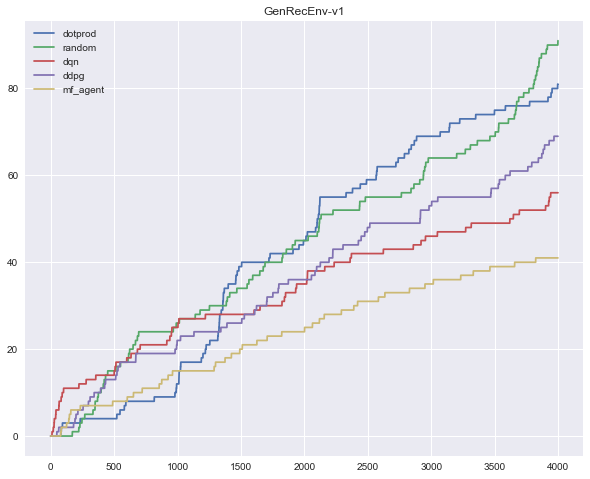

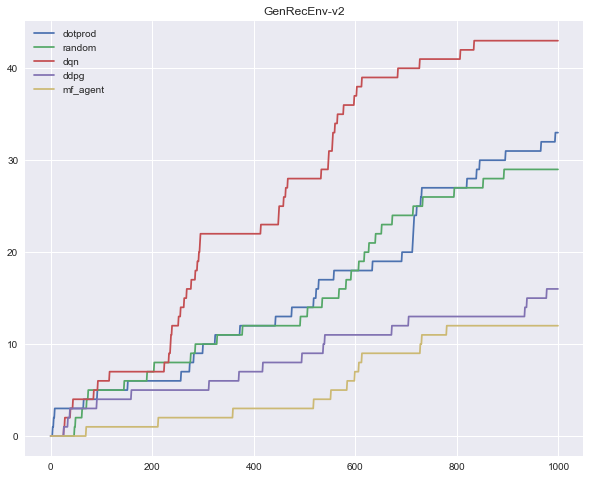

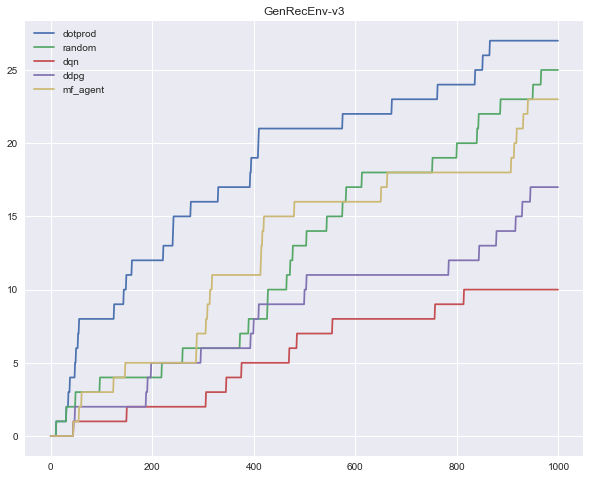

In [8]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

for envid, res in results.items():
    
    plt.figure(figsize=(10, 8))
    
    for agent_name, interactions in res.items():
        rewards = []
        for i in interactions:
            rewards.extend(i.rewards)
        
        plt.plot(np.cumsum(rewards), label=agent_name)
    
    plt.legend()
    plt.title(envid)
    
#results['MovieLens-v1']['ddpg']